# Effects of maintenance levels on rental prices in different municipality categories
## By Yannick Mariman

## Investigation Overview

> In this investigation, I wanted to look at the characteristics of rental house transactions that could be used to predict their prices. The main focus was on maintenance levels, energy labels, and housing type.

## Dataset Overview

> The data consisted of prices and features of approximately 534,000 rental transactions. The features included maintenance levels inside, maintenance levels outside, energylabel, housing type, as well as additional measurements such as transaction date, time between online and transaction, location, and neighbourhood. 202.998 data points were removed from the analysis due to inconsistencies or missing information.

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

# load in the dataset into a pandas dataframe
# import all packages and set plots to be embedded inline

from pathlib import Path

%matplotlib inline

# pd.set_option('max_rows',100)
pd.set_option('min_rows',20)

pd.set_option('max_columns',100)

df_raw = pd.read_csv(
    r'D:\OneDrive - MVGM\WerkbestandenYannick\Werkmap_Python\Projecten\wh\data\batch_huur_20210623\input\factiararems-23-06-21.csv'
, dtype={'SoortGarage':str, 'Land':str, 'HuurprijsConditie':str, 'HuurprijsSpecificatie':str,
       'KadastraalEigendom':str, 'KadastraalOmvang':str, 'MakelaarNaam':str, 'STATUS':str,
       'StatusVerhuurd':str})

df_raw = df_raw[['Bron', 'Bouwjaar', 'EnergieLabel', 'GebruiksOppervlakte', 'AanmeldDatum', 'Postcode',
       'TypeWoning', 'Looptijd', 'Ingetrokken', 'TransactieHuurPrijs',
       'SoortAppartement',
       'TransactieDatumOndertekeningAkte', 'OnderhoudsNiveauBinnen', 'OnderhoudsNiveauBuiten',
       'GemeenteNaam','HuurprijsConditie']]

df = df_raw.copy(deep=True)

# Read the data
df = df_raw.copy(deep=True)

# Some data wrangling such that the data can be used for visualisation

# Energielabels / energylabels
df.EnergieLabel = df.EnergieLabel.fillna('C') # Median
df.EnergieLabel = df.EnergieLabel.replace({"A+++++":"A", "A++++":"A", "A+++":"A", "A++":"A", "A+":"A"})

# column formatting
df.OnderhoudsNiveauBinnen = df.OnderhoudsNiveauBinnen.str.capitalize()
df.OnderhoudsNiveauBuiten = df.OnderhoudsNiveauBuiten.str.capitalize()
df.GebruiksOppervlakte = df.GebruiksOppervlakte.round(0)
df.AanmeldDatum = pd.to_datetime(df.AanmeldDatum)
df.TransactieDatumOndertekeningAkte = pd.to_datetime(df.TransactieDatumOndertekeningAkte)
df.TypeWoning = df.TypeWoning.where(df.TypeWoning.notna(), df.SoortAppartement)
df.TypeWoning = df.TypeWoning.str.capitalize()

# Since there are too many municipalities. They are classified in the 4 biggest municipalities, the 5th until the 45th biggest municipalities and the rest.
# This is an usual classification for classifications in the Neterlands
G4 = ['Amsterdam','Utrecht','Rotterdam',"'s-Gravenhage"]
G40 = ['Alkmaar', 'Almelo', 'Almere', 'Alphen aan den Rijn', 'Amersfoort', 'Apeldoorn', 'Arnhem', 'Assen', 'Breda', 'Delft', 'Deventer', 'Dordrecht', 'Ede', 'Eindhoven', 'Emmen', 'Enschede', 'Gouda', 'Groningen', 'Haarlem', 'Haarlemmermeer', 'Heerlen', 'Helmond', 'Hengelo', "'s-Hertogenbosch", 'Hilversum', 'Hoorn', 'Leeuwarden', 'Leiden', 'Lelystad', 'Maastricht', 'Nijmegen', 'Oss', 'Roosendaal', 'Sittard-Geleen', 'Schiedam', 'Tilburg', 'Venlo', 'Zaanstad', 'Zoetermeer','Zwolle']
df['GemeenteCat'] = df.GemeenteNaam.where(~df.GemeenteNaam.isin(G4), 'G4').where(~df.GemeenteNaam.isin(G40), 'G40').where(df.GemeenteNaam.isin(G4+G40), 'Overig')

#Categorical values
# Sorted from less good to 'better'
ordinal_var_dict = {'EnergieLabel': ['G','F','E','D','C', 'B', 'A'],
                    'OnderhoudsNiveauBinnen': ['Slecht', 'Slecht tot matig', 'Matig', 'Matig tot redelijk'
                                               , 'Redelijk', 'Redelijk tot goed', 'Goed', 'Goed tot uitstekend', 'Uitstekend'],
                    'OnderhoudsNiveauBuiten': ['Slecht', 'Slecht tot matig', 'Matig', 'Matig tot redelijk'
                                               , 'Redelijk', 'Redelijk tot goed', 'Goed', 'Goed tot uitstekend', 'Uitstekend'],
                    'GemeenteCat': ['G4', 'G40', 'Overig'],
                   }
for var in ordinal_var_dict:
    ordered_var = pd.api.types.CategoricalDtype(ordered = True,categories = ordinal_var_dict[var])
    df[var] = df[var].astype(ordered_var)

df.TypeWoning.where(df.TypeWoning.notna(), 'Onbekend', inplace=True)
for i in range(1,9):
    df.TypeWoning.where(~df.TypeWoning.str.contains(f'{i}-k flat'), f'{i}-k flatwoning', inplace=True)
df.TypeWoning.where(~df.TypeWoning.str.contains('Flat'), 'Flatwoning', inplace=True)

# Only include the 16 most used WoningTypes. All types with more than 10k entries
l = df.TypeWoning.value_counts(dropna=False).index[:16]
df = df[df.TypeWoning.isin(l)]

# Only look at transactions which are really made.
df = df[df.Ingetrokken==0]
df.drop(columns=['SoortAppartement','Ingetrokken'], inplace=True)

df.TransactieHuurPrijs.where((df.HuurprijsConditie=='per maand') | (df.HuurprijsConditie.isnull()), df.TransactieHuurPrijs/12, inplace=True)
df.drop(columns='HuurprijsConditie', inplace=True)

df.where((df.GebruiksOppervlakte > 5) & (df.GebruiksOppervlakte < 700), inplace=True)

# Cap the renting prices. From my work I know that the prices generally do not exceed 2500 but there are existing outliers of habitats with outliers around 6k per month
df = df[df.TransactieHuurPrijs < 6_500]

df.GebruiksOppervlakte.fillna(1, inplace=True)

df.GebruiksOppervlakte = df.GebruiksOppervlakte.astype(int)

df.insert(2, 'M2HuurPrijs', df.TransactieHuurPrijs / df.GebruiksOppervlakte)

df.Bouwjaar = df.Bouwjaar.where(df.Bouwjaar<=2021).where(df.Bouwjaar>1500)

> Note that the above cells have been set as "Skip"-type slides. That means
that when the notebook is rendered as http slides, those cells won't show up.

## Distribution of square metre prices

> Square metre prices (€/m2) have a wide range of values from 2 to around 50 but more centered around 10/20. If the square metre prices are plotted on a logaritmic scale the distribution takes on an unimodal shape.

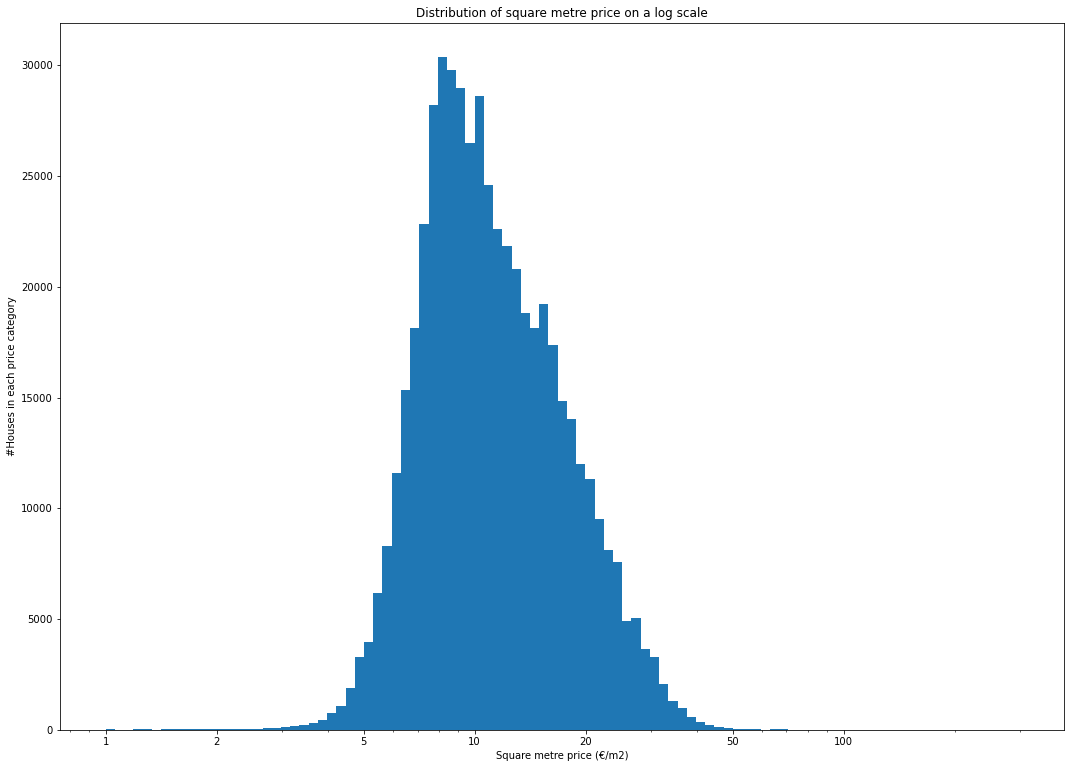

In [2]:
# start with a standard-scaled plot
log_binsize = 0.025
bins = 10 ** np.arange(0, np.log10(df['M2HuurPrijs'].max())+log_binsize, log_binsize)


plt.figure(figsize=[ 18, 13])
plt.hist(data = df, x = 'M2HuurPrijs', bins = bins)
plt.xscale('log')
plt.xticks([1, 2, 5, 10, 20, 50, 100], [1, 2, 5, 10, 20, 50, 100]) #[0, 5, 10, 15, 20, 25, 30, 35, 40])
plt.xlabel('Square metre price (€/m2)')
plt.ylabel('#Houses in each price category')
plt.title("Distribution of square metre price on a log scale")
plt.show()

## Square metre prices for different municipality categories

> The housing types prices vary a lot per municipality category. Every category has a lot of outliers and G40 and 'Overig' are similar. G4 is in a totally different with a median higher than the upper quartiles of the other municipality categories.

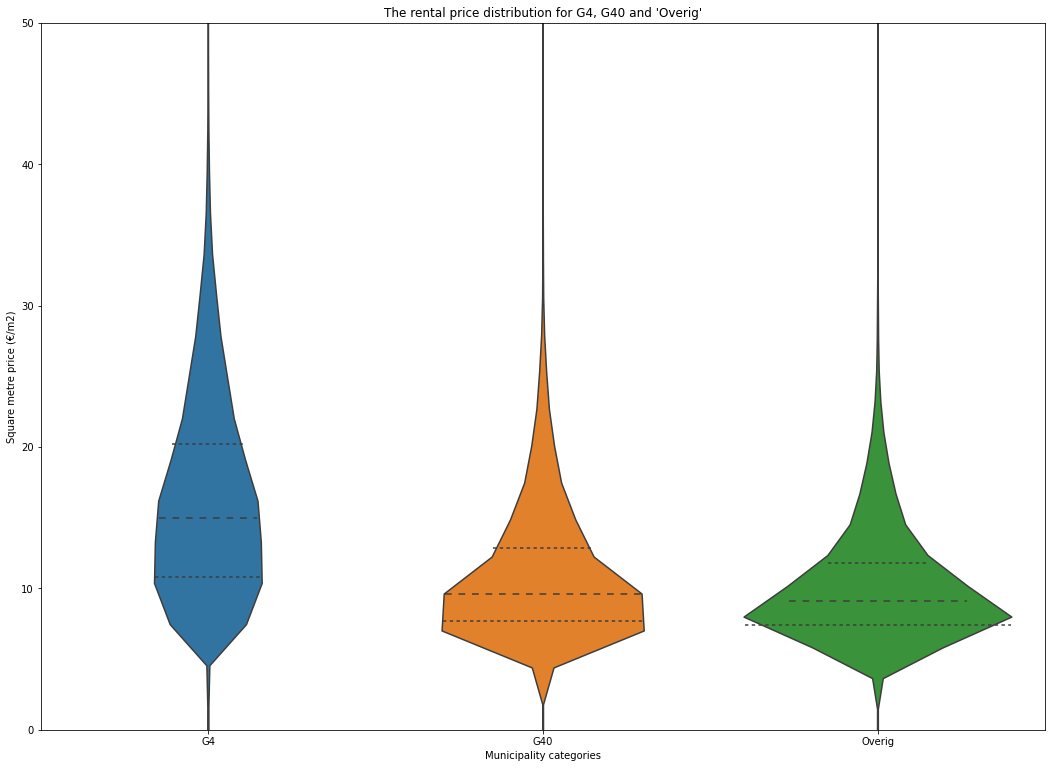

In [3]:
plt.figure(figsize=[ 18, 13])
sns.violinplot(data=df, y='M2HuurPrijs', x='GemeenteCat', inner='quartile');
plt.ylim(0, 50)
plt.ylabel("Square metre price (€/m2)")
plt.xlabel("Municipality categories")
plt.title("The rental price distribution for G4, G40 and 'Overig'");

## Square metre prices for different maintenance levels

> The housing types prices don't vary a lot per housing category. Even though a slight trend can be found in mean square metre price per category. The amount of outliers is higher with higher maintenance levels. 'Redelijk' is an outlier that can be explained by the domain expert, because it is the default value when this data is created.

<Figure size 841.68x595.44 with 0 Axes>

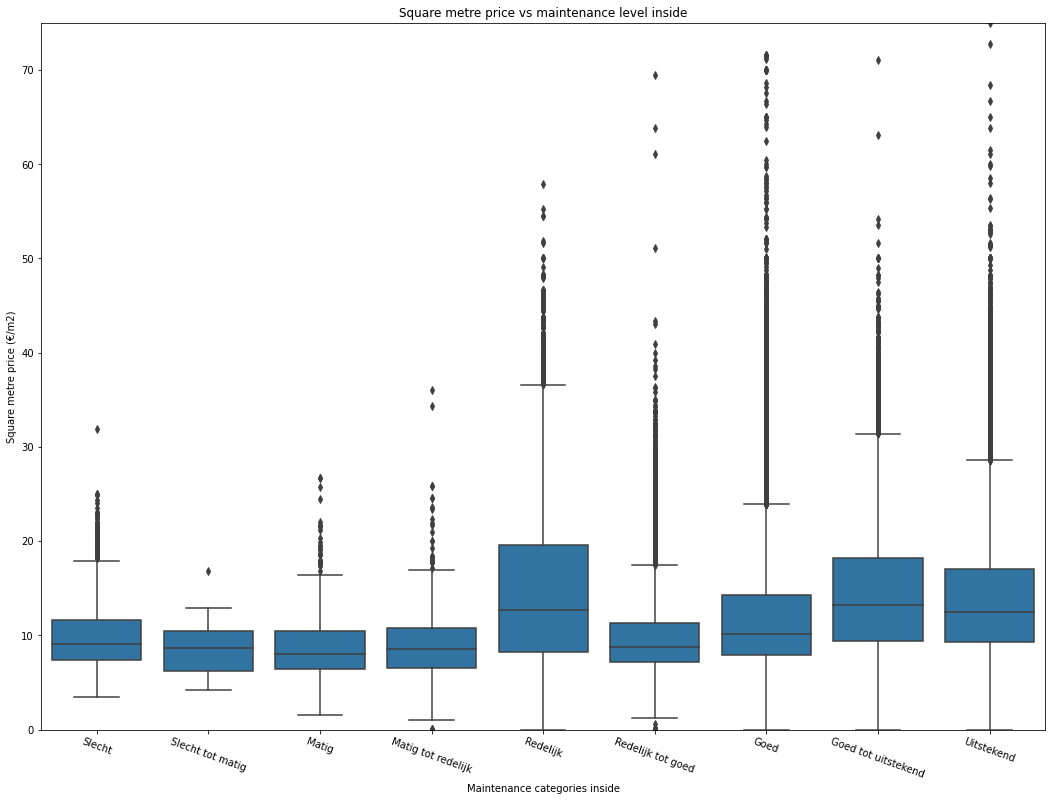

In [4]:
plt.figure(figsize=[ 11.69, 8.27])
plt.figure(figsize=[ 18, 13])
base_color = sns.color_palette()[0]
sns.boxplot(data=df, y='M2HuurPrijs', x='OnderhoudsNiveauBinnen', color=base_color)
plt.title('Square metre price vs maintenance level inside')
plt.ylim(0, 75)
plt.ylabel('Square metre price (€/m2)')
plt.xlabel('Maintenance categories inside')
plt.xticks(rotation=-20);
plt.show()

<Figure size 841.68x595.44 with 0 Axes>

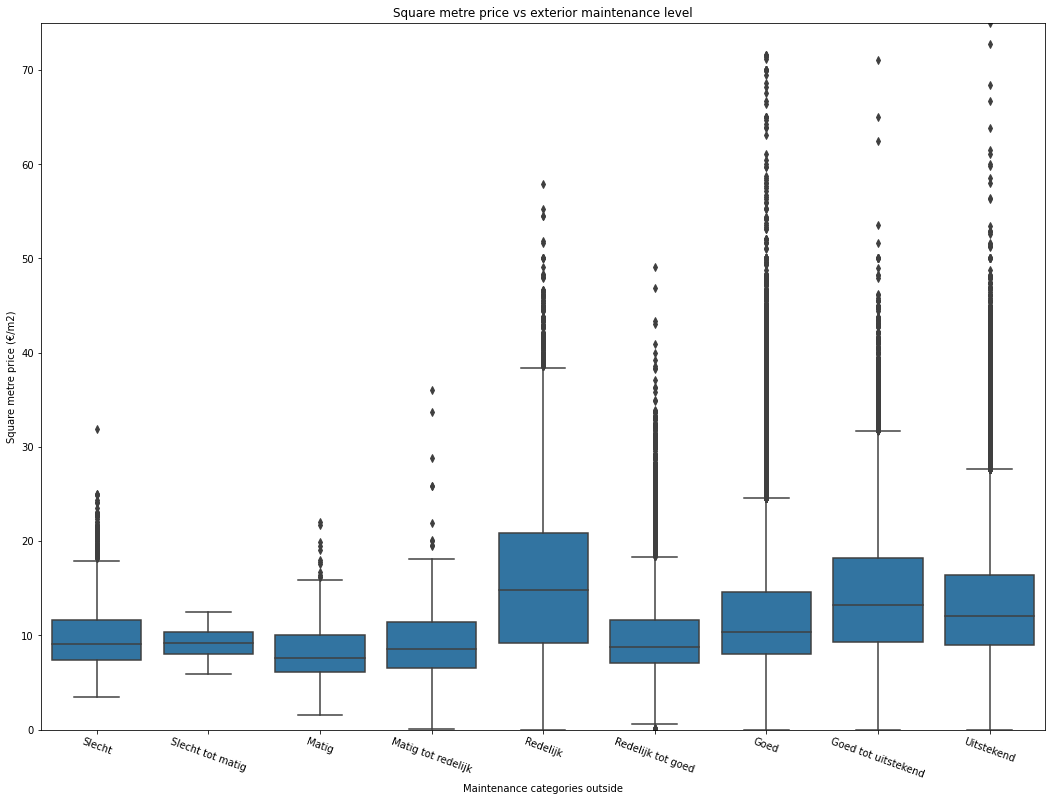

In [5]:
plt.figure(figsize=[ 11.69, 8.27])
plt.figure(figsize=[ 18, 13])

sns.boxplot(data=df, y='M2HuurPrijs', x='OnderhoudsNiveauBuiten', color=base_color)
plt.title('Square metre price vs exterior maintenance level')
plt.ylim(0, 75)
plt.ylabel('Square metre price (€/m2)')
plt.xlabel('Maintenance categories outside')
plt.xticks(rotation=-20);
plt.show()

## Square metre prices for different maintenance levels for different municipality categories

> The housing prices seem to increase for higher maintenance levels. Prices for G4 are also higher generally a lot higher than for the other categories. This goes for maintenance levels inside as well as outside. Again, 'Redelijk' can be seen as an outlier. For every category a higher maintenance level implies a higher square metre price.

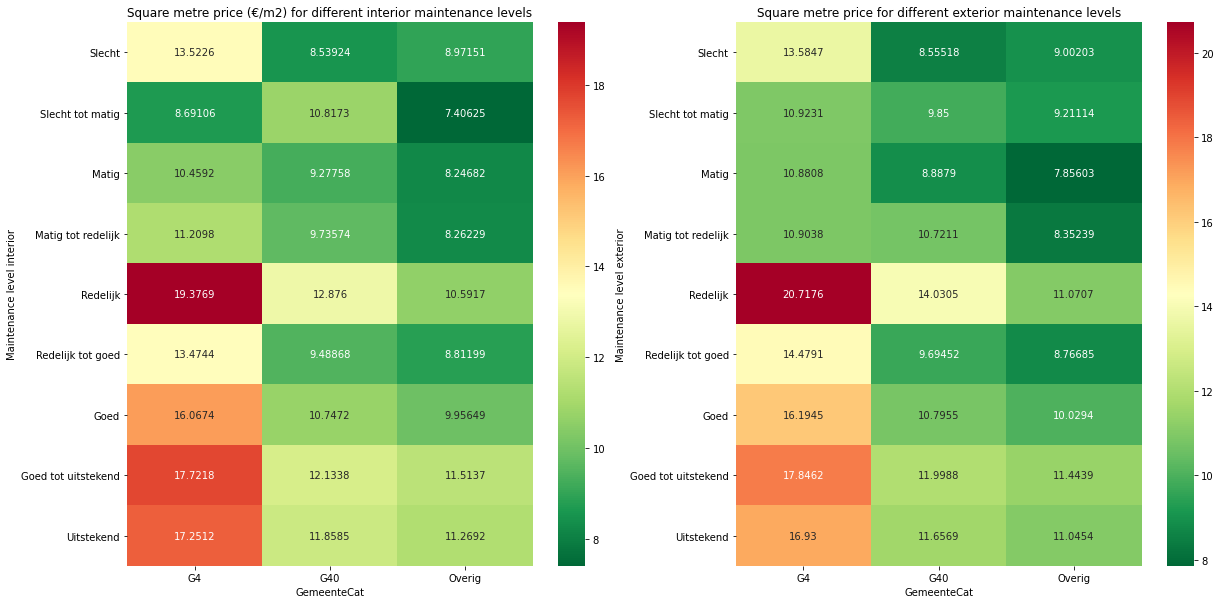

In [6]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

plt.title("Square metre prices for different maintenance levels inside and outside.")

ax1.set_title('Square metre price (€/m2) for different interior maintenance levels');
heat_df = df.rename(columns={"OnderhoudsNiveauBinnen": "Maintenance level interior"}).groupby(["Maintenance level interior",'GemeenteCat']).mean()['M2HuurPrijs'].unstack()
sns.heatmap(heat_df, cmap='RdYlGn_r', annot=True, fmt='g', ax=ax1);
plt.ylabel("Maintenance level interior")
# plt.show()

ax2.set_title('Square metre price for different exterior maintenance levels') #'#Transactions per category square metre price for different maintenance levels inside');
heat_df = df.groupby(['OnderhoudsNiveauBuiten','GemeenteCat']).mean()['M2HuurPrijs'].unstack()
sns.heatmap(heat_df, cmap='RdYlGn_r', annot=True, fmt='g', ax=ax2);
plt.ylabel("Maintenance level exterior")
plt.show()

> Once you're ready to finish your presentation, check your output by using
nbconvert to export the notebook and set up a server for the slides. From the
terminal or command line, use the following expression:
> > `jupyter nbconvert <file_name>.ipynb --to slides --post serve --template output_toggle`

> This should open a tab in your web browser where you can scroll through your
presentation. Sub-slides can be accessed by pressing 'down' when viewing its parent
slide. Make sure you remove all of the quote-formatted guide notes like this one
before you finish your presentation!

In [7]:
# !jupyter nbconvert renting_vizualisation.ipynb --to slides --post serve --template output_toggle.tpl --no-input --no-prompt

jupyter nbconvert renting_vizualisation.ipynb --to slides --post serve --no-input --no-prompt

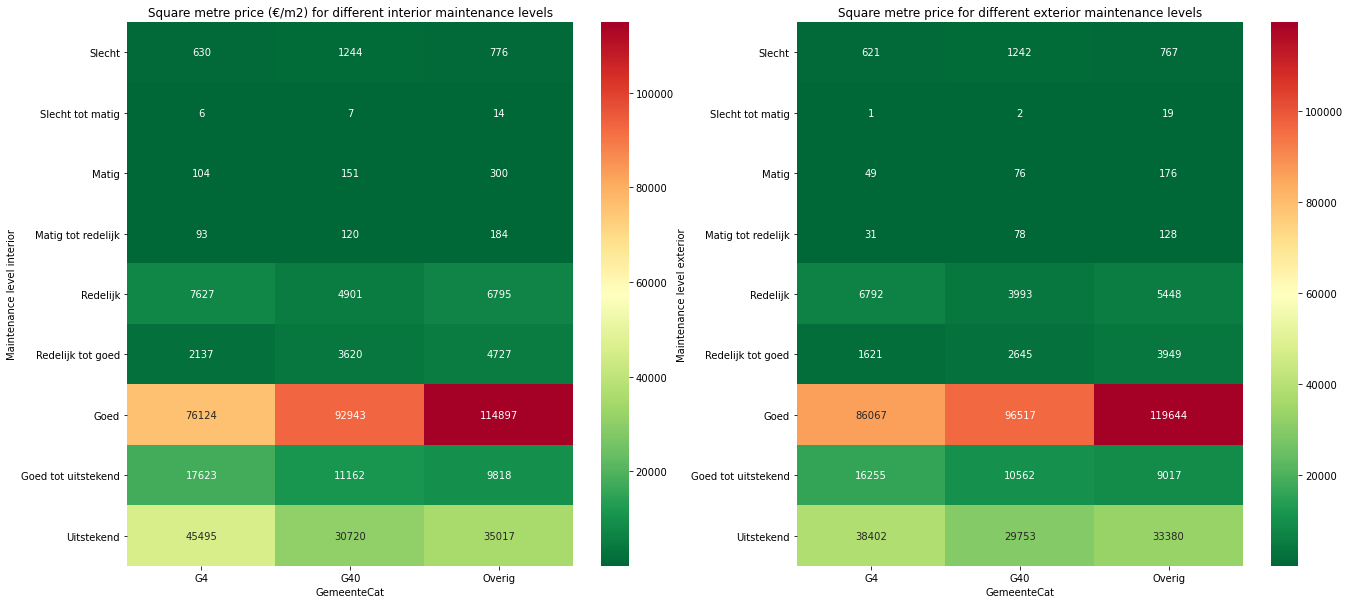

In [8]:
fig = plt.figure(figsize=(22,10))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

plt.title("Square metre prices for different maintenance levels inside and outside.")

ax1.set_title('Square metre price (€/m2) for different interior maintenance levels');
heat_df = df.rename(columns={"OnderhoudsNiveauBinnen": "Maintenance level interior"}).groupby(["Maintenance level interior",'GemeenteCat']).count()['M2HuurPrijs'].unstack()
sns.heatmap(heat_df, cmap='RdYlGn_r', annot=True, fmt='g', ax=ax1);
plt.ylabel("Maintenance level interior")
# plt.show()

ax2.set_title('Square metre price for different exterior maintenance levels') #'#Transactions per category square metre price for different maintenance levels inside');
heat_df = df.groupby(['OnderhoudsNiveauBuiten','GemeenteCat']).count()['M2HuurPrijs'].unstack()
sns.heatmap(heat_df, cmap='RdYlGn_r', annot=True, fmt='g', ax=ax2);
plt.ylabel("Maintenance level exterior")
plt.show()